# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part3 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load Face datasets
Unzip the face_dataset.tar.gz in data directory as follows.<br>
**cd ./data**<br>
**tar -xf face_dataset.tar.gz**<br>

Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [3]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

[ 1.56834639  1.73720325 -0.92972867]
(64, 64, 3)


[ 0.16985062  0.42270934 -1.28218444]
(64, 64, 3)


[ 0.99774898 -0.15737693 -0.75644725]
(64, 64, 3)


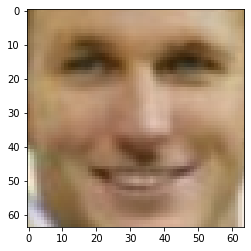

[ 1.12271853  1.91614437 -2.51421429]
(64, 64, 3)


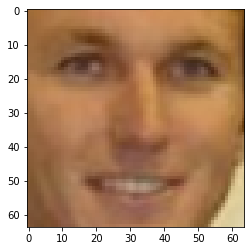

[ 1.07821424  1.67621104 -2.27805594]
(64, 64, 3)


In [4]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])
    print(im[i].shape)

## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [7]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 300
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 3
channel = 3
output_size = 64


It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [8]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    #### TODO ####
    with tf.variable_scope('gen'):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        z_input = tf.reshape(z, [-1, 1, 1, sample_size])
        y_label = tf.reshape(y, [-1, 1, 1, y_dim])
        inputs = tf.concat([z, y], 1)
        
        # project layer
        proj_size = 4*4*1024
        W = tf.get_variable("W0", [sample_size + y_dim, proj_size], initializer=w_init)
        b = tf.get_variable("b0", [proj_size], initializer=b_init)
        projected = lrelu(batch_normal(fully_connect(inputs, W, b), scope='bn0'))
        reshape = tf.reshape(projected, [batch_size, 4, 4, 1024])

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, 512, 1024], initializer=w_init)
        b = tf.get_variable("b1", [512], initializer=b_init)
        deconv1 = lrelu(batch_normal(de_conv(reshape, W, b, [batch_size, 8, 8, 512]), scope='bn1'))

        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, 256, 512], initializer=w_init)
        b = tf.get_variable("b2", [256], initializer=b_init)
        deconv2 = lrelu(batch_normal(de_conv(deconv1, W, b, [batch_size, 16, 16, 256]), scope='bn2'))
        
        # 3nd hidden layer
        W = tf.get_variable("W3", [5, 5, 128, 256], initializer=w_init)
        b = tf.get_variable("b3", [128], initializer=b_init)
        deconv3 = lrelu(batch_normal(de_conv(deconv2, W, b, [batch_size, 32, 32, 128]), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [5, 5, 3, 128], initializer=w_init)
        b = tf.get_variable("b4", [3], initializer=b_init)
        deconv3 = de_conv(deconv3, W, b, [batch_size, 64, 64, 3])
        o = tf.nn.tanh(deconv3)

        return o
    

Now, it's time for a discriminative model. Again, you can change anything if you need

In [9]:
def dis_net(data_array , y, batch_size, y_dim, reuse=False):
    #### TODO ####
    with tf.variable_scope('dis', reuse=reuse):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        yb = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(data_array, yb)

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, x.get_shape()[-1], channel+y_dim], initializer=w_init)
        b = tf.get_variable("b1", [channel+y_dim], initializer=b_init)
        conv1 = lrelu(conv2d(x, W, b))
        
        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, conv1.get_shape()[-1], 64], initializer=w_init)
        b = tf.get_variable("b2", [64], initializer=b_init)
        conv2 = lrelu(batch_normal(conv2d(conv1, W, b), scope='bn2'))
        conv2_flatten = tf.reshape(conv2, [batch_size, -1])
        
        # 3rd hidden layer
        W = tf.get_variable("W3", [conv2_flatten.get_shape()[-1], 1024], initializer=w_init)
        b = tf.get_variable("b3", [1024], initializer=b_init)
        out3 = lrelu(batch_normal(fully_connect(conv2_flatten, W, b), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [1024, 1], initializer=w_init)
        b = tf.get_variable("b4", [1], initializer=b_init)
        logits = fully_connect(out3, W, b)
        o = tf.nn.sigmoid(logits)

        return o, logits


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [10]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

sample_dir = 'samples_for_test_faces'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


EPOCH 0 step 50: D: loss = 1.4008970 G: loss=0.6835856 
EPOCH 0 step 100: D: loss = 1.4010782 G: loss=0.6775932 


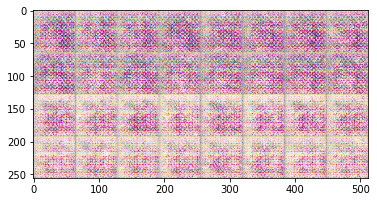

EPOCH 1 step 150: D: loss = 1.3917377 G: loss=0.6895059 
EPOCH 1 step 200: D: loss = 1.3883343 G: loss=0.6854517 
EPOCH 2 step 250: D: loss = 1.3878767 G: loss=0.6895353 
EPOCH 2 step 300: D: loss = 1.3831953 G: loss=0.6911979 
EPOCH 3 step 350: D: loss = 1.3886940 G: loss=0.6872544 
EPOCH 3 step 400: D: loss = 1.3913593 G: loss=0.6905904 
EPOCH 4 step 450: D: loss = 1.3877531 G: loss=0.6878802 
EPOCH 4 step 500: D: loss = 1.3844768 G: loss=0.6887016 
EPOCH 5 step 550: D: loss = 1.3817260 G: loss=0.6874136 
EPOCH 5 step 600: D: loss = 1.3902619 G: loss=0.6901762 
EPOCH 6 step 650: D: loss = 1.3883692 G: loss=0.6932597 
EPOCH 6 step 700: D: loss = 1.3896005 G: loss=0.6924360 
EPOCH 7 step 750: D: loss = 1.3802956 G: loss=0.6939162 
EPOCH 7 step 800: D: loss = 1.3906651 G: loss=0.6906065 
EPOCH 8 step 850: D: loss = 1.3900888 G: loss=0.6964707 
EPOCH 8 step 900: D: loss = 1.3853083 G: loss=0.6936175 
EPOCH 9 step 950: D: loss = 1.3790729 G: loss=0.6905519 
EPOCH 9 step 1000: D: loss = 1.

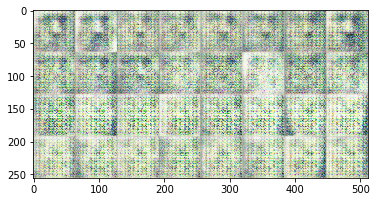

EPOCH 11 step 1150: D: loss = 1.3904712 G: loss=0.6877254 
EPOCH 11 step 1200: D: loss = 1.3836803 G: loss=0.6877763 
EPOCH 12 step 1250: D: loss = 1.3849099 G: loss=0.6879754 
EPOCH 12 step 1300: D: loss = 1.3822011 G: loss=0.6912366 
EPOCH 13 step 1350: D: loss = 1.3812156 G: loss=0.6947132 
EPOCH 13 step 1400: D: loss = 1.3799609 G: loss=0.6917329 
EPOCH 14 step 1450: D: loss = 1.3834400 G: loss=0.6922143 
EPOCH 14 step 1500: D: loss = 1.3851676 G: loss=0.6865152 
EPOCH 15 step 1550: D: loss = 1.3788319 G: loss=0.6945729 
EPOCH 15 step 1600: D: loss = 1.3906256 G: loss=0.6885525 
EPOCH 16 step 1650: D: loss = 1.3769531 G: loss=0.6858044 
EPOCH 16 step 1700: D: loss = 1.3832867 G: loss=0.6910350 
EPOCH 17 step 1750: D: loss = 1.3822101 G: loss=0.6933196 
EPOCH 17 step 1800: D: loss = 1.3807845 G: loss=0.6938658 
EPOCH 18 step 1850: D: loss = 1.3781619 G: loss=0.6973154 
EPOCH 18 step 1900: D: loss = 1.3760114 G: loss=0.6947884 
EPOCH 19 step 1950: D: loss = 1.3741071 G: loss=0.695486

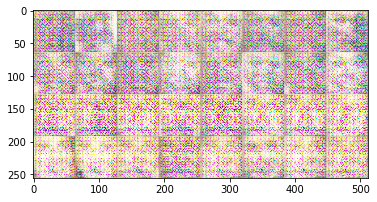

EPOCH 21 step 2150: D: loss = 1.3828038 G: loss=0.6915915 
EPOCH 21 step 2200: D: loss = 1.3701966 G: loss=0.6933157 
EPOCH 22 step 2250: D: loss = 1.3720000 G: loss=0.6921589 
EPOCH 22 step 2300: D: loss = 1.3570474 G: loss=0.7066758 
EPOCH 23 step 2350: D: loss = 1.3741335 G: loss=0.6838309 
EPOCH 23 step 2400: D: loss = 1.3574462 G: loss=0.6974583 
EPOCH 24 step 2450: D: loss = 1.3611659 G: loss=0.6915287 
EPOCH 24 step 2500: D: loss = 1.3491845 G: loss=0.7001420 
EPOCH 24 step 2550: D: loss = 1.3614271 G: loss=0.6998080 
EPOCH 25 step 2600: D: loss = 1.3606174 G: loss=0.6888000 
EPOCH 25 step 2650: D: loss = 1.3501961 G: loss=0.7028929 
EPOCH 26 step 2700: D: loss = 1.3457915 G: loss=0.6982781 
EPOCH 26 step 2750: D: loss = 1.3540843 G: loss=0.6810114 
EPOCH 27 step 2800: D: loss = 1.3484471 G: loss=0.7008628 
EPOCH 27 step 2850: D: loss = 1.3356066 G: loss=0.7091129 
EPOCH 28 step 2900: D: loss = 1.3298547 G: loss=0.7082231 
EPOCH 28 step 2950: D: loss = 1.3231173 G: loss=0.704814

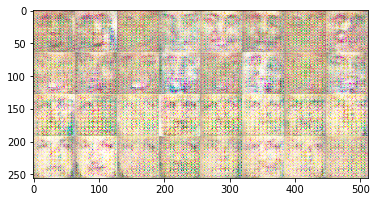

EPOCH 31 step 3200: D: loss = 1.3123209 G: loss=0.7058349 
EPOCH 31 step 3250: D: loss = 1.3029633 G: loss=0.7446347 
EPOCH 32 step 3300: D: loss = 1.2714424 G: loss=0.7251047 
EPOCH 32 step 3350: D: loss = 1.2541609 G: loss=0.7299494 
EPOCH 33 step 3400: D: loss = 1.2470050 G: loss=0.7438164 
EPOCH 33 step 3450: D: loss = 1.2552395 G: loss=0.7435173 
EPOCH 34 step 3500: D: loss = 1.2194849 G: loss=0.7538961 
EPOCH 34 step 3550: D: loss = 1.2394058 G: loss=0.7522314 
EPOCH 35 step 3600: D: loss = 1.2297137 G: loss=0.7407463 
EPOCH 35 step 3650: D: loss = 1.2047342 G: loss=0.7421906 
EPOCH 36 step 3700: D: loss = 1.2606262 G: loss=0.7612169 
EPOCH 36 step 3750: D: loss = 1.2180219 G: loss=0.7680730 
EPOCH 37 step 3800: D: loss = 1.2076703 G: loss=0.7561461 
EPOCH 37 step 3850: D: loss = 1.1594011 G: loss=0.7826545 
EPOCH 38 step 3900: D: loss = 1.1763446 G: loss=0.7819307 
EPOCH 38 step 3950: D: loss = 1.2078525 G: loss=0.7686027 
EPOCH 39 step 4000: D: loss = 1.1611085 G: loss=0.777244

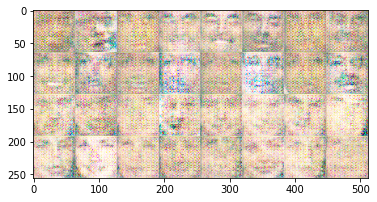

EPOCH 41 step 4200: D: loss = 1.0775043 G: loss=0.8302881 
EPOCH 41 step 4250: D: loss = 1.1233091 G: loss=0.8033384 
EPOCH 42 step 4300: D: loss = 1.1593335 G: loss=0.8340110 
EPOCH 42 step 4350: D: loss = 1.1435976 G: loss=0.7862588 
EPOCH 43 step 4400: D: loss = 1.1298411 G: loss=0.8282262 
EPOCH 43 step 4450: D: loss = 1.1026838 G: loss=0.8286735 
EPOCH 44 step 4500: D: loss = 1.0920695 G: loss=0.8238195 
EPOCH 44 step 4550: D: loss = 1.1032944 G: loss=0.8496383 
EPOCH 45 step 4600: D: loss = 1.0429971 G: loss=0.8679244 
EPOCH 45 step 4650: D: loss = 1.4661890 G: loss=0.9764609 
EPOCH 46 step 4700: D: loss = 1.2017524 G: loss=0.8077066 
EPOCH 46 step 4750: D: loss = 1.0582204 G: loss=0.8955868 
EPOCH 47 step 4800: D: loss = 0.9792089 G: loss=0.9023623 
EPOCH 47 step 4850: D: loss = 0.9815388 G: loss=0.9137850 
EPOCH 48 step 4900: D: loss = 1.0279343 G: loss=0.8786110 
EPOCH 48 step 4950: D: loss = 0.9982097 G: loss=0.8916800 
EPOCH 49 step 5000: D: loss = 0.9861629 G: loss=0.902409

EPOCH 51 step 5250: D: loss = 0.9495643 G: loss=0.9273270 
EPOCH 51 step 5300: D: loss = 0.9889114 G: loss=0.8966637 
EPOCH 52 step 5350: D: loss = 0.9471684 G: loss=0.9790303 
EPOCH 52 step 5400: D: loss = 0.9833577 G: loss=0.9193652 
EPOCH 53 step 5450: D: loss = 0.9073120 G: loss=0.9338907 
EPOCH 53 step 5500: D: loss = 0.9735757 G: loss=0.9237949 
EPOCH 54 step 5550: D: loss = 0.8966537 G: loss=0.9824821 
EPOCH 54 step 5600: D: loss = 0.9359872 G: loss=0.9485270 
EPOCH 55 step 5650: D: loss = 0.8676941 G: loss=0.9626260 
EPOCH 55 step 5700: D: loss = 0.8992617 G: loss=0.9521324 
EPOCH 56 step 5750: D: loss = 0.8888717 G: loss=0.9890277 
EPOCH 56 step 5800: D: loss = 1.6752892 G: loss=1.8416258 
EPOCH 57 step 5850: D: loss = 0.9511529 G: loss=1.1031065 
EPOCH 57 step 5900: D: loss = 0.7624559 G: loss=1.1049496 
EPOCH 58 step 5950: D: loss = 0.8274350 G: loss=1.1425378 
EPOCH 58 step 6000: D: loss = 0.7952235 G: loss=1.0916862 
EPOCH 59 step 6050: D: loss = 0.7506992 G: loss=1.111169

EPOCH 61 step 6250: D: loss = 0.7959876 G: loss=1.0515959 
EPOCH 61 step 6300: D: loss = 0.8022851 G: loss=1.0499060 
EPOCH 62 step 6350: D: loss = 0.8024790 G: loss=1.0072608 
EPOCH 62 step 6400: D: loss = 0.8175089 G: loss=1.0415345 
EPOCH 63 step 6450: D: loss = 0.7649864 G: loss=1.1119206 
EPOCH 63 step 6500: D: loss = 0.8601314 G: loss=1.0321789 
EPOCH 64 step 6550: D: loss = 0.7816997 G: loss=1.1157594 
EPOCH 64 step 6600: D: loss = 0.8135639 G: loss=0.9879600 
EPOCH 65 step 6650: D: loss = 0.7589217 G: loss=1.1351075 
EPOCH 65 step 6700: D: loss = 0.7994900 G: loss=1.0320841 
EPOCH 66 step 6750: D: loss = 0.7047029 G: loss=1.1185771 
EPOCH 66 step 6800: D: loss = 0.8434744 G: loss=1.0547420 
EPOCH 67 step 6850: D: loss = 0.7201546 G: loss=1.1212996 
EPOCH 67 step 6900: D: loss = 0.8207195 G: loss=1.1039753 
EPOCH 68 step 6950: D: loss = 0.7445806 G: loss=1.1050036 
EPOCH 68 step 7000: D: loss = 0.8918675 G: loss=1.1349676 
EPOCH 69 step 7050: D: loss = 0.7283496 G: loss=1.106257

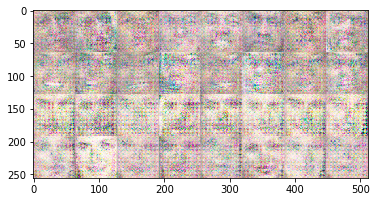

EPOCH 71 step 7250: D: loss = 0.7145921 G: loss=1.1420288 
EPOCH 71 step 7300: D: loss = 0.7284232 G: loss=1.1484861 
EPOCH 72 step 7350: D: loss = 0.6950363 G: loss=1.1063089 
EPOCH 72 step 7400: D: loss = 0.6918804 G: loss=1.1409721 
EPOCH 73 step 7450: D: loss = 0.6944312 G: loss=1.2050971 
EPOCH 73 step 7500: D: loss = 0.6456538 G: loss=1.2159051 
EPOCH 74 step 7550: D: loss = 0.6705850 G: loss=1.1765072 
EPOCH 74 step 7600: D: loss = 0.6129409 G: loss=1.2058563 
EPOCH 74 step 7650: D: loss = 0.6854324 G: loss=1.2415454 
EPOCH 75 step 7700: D: loss = 0.6144413 G: loss=1.1912767 
EPOCH 75 step 7750: D: loss = 0.7054305 G: loss=1.1944275 
EPOCH 76 step 7800: D: loss = 0.6369607 G: loss=1.2413542 
EPOCH 76 step 7850: D: loss = 0.6698480 G: loss=1.2015206 
EPOCH 77 step 7900: D: loss = 0.6154923 G: loss=1.2363425 
EPOCH 77 step 7950: D: loss = 0.6318755 G: loss=1.2763319 
EPOCH 78 step 8000: D: loss = 0.6158602 G: loss=1.2188125 
EPOCH 78 step 8050: D: loss = 0.7513695 G: loss=1.302469

EPOCH 81 step 8300: D: loss = 0.6374327 G: loss=1.3070956 
EPOCH 81 step 8350: D: loss = 0.5886112 G: loss=1.3313737 
EPOCH 82 step 8400: D: loss = 0.5502564 G: loss=1.3099720 
EPOCH 82 step 8450: D: loss = 0.5618908 G: loss=1.3251978 
EPOCH 83 step 8500: D: loss = 0.6045351 G: loss=1.3873662 
EPOCH 83 step 8550: D: loss = 0.5641949 G: loss=1.2913055 
EPOCH 84 step 8600: D: loss = 0.5266603 G: loss=1.4383899 
EPOCH 84 step 8650: D: loss = 0.5678800 G: loss=1.3129320 
EPOCH 85 step 8700: D: loss = 0.6231144 G: loss=1.3785198 
EPOCH 85 step 8750: D: loss = 0.5642403 G: loss=1.3165554 
EPOCH 86 step 8800: D: loss = 0.5450720 G: loss=1.3330441 
EPOCH 86 step 8850: D: loss = 0.5764707 G: loss=1.3256534 
EPOCH 87 step 8900: D: loss = 0.5858750 G: loss=1.3533682 
EPOCH 87 step 8950: D: loss = 0.5567305 G: loss=1.3053489 
EPOCH 88 step 9000: D: loss = 0.5515296 G: loss=1.3987885 
EPOCH 88 step 9050: D: loss = 0.5951884 G: loss=1.3413236 
EPOCH 89 step 9100: D: loss = 0.5626985 G: loss=1.402850

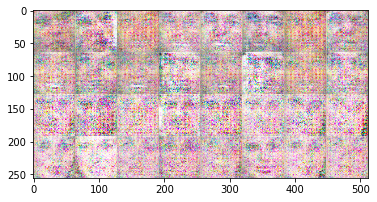

EPOCH 91 step 9300: D: loss = 0.5494708 G: loss=1.5044391 
EPOCH 91 step 9350: D: loss = 0.5280723 G: loss=1.3899001 
EPOCH 92 step 9400: D: loss = 0.5361426 G: loss=1.4193161 
EPOCH 92 step 9450: D: loss = 0.5925649 G: loss=1.4949317 
EPOCH 93 step 9500: D: loss = 0.5218332 G: loss=1.3793612 
EPOCH 93 step 9550: D: loss = 0.5258049 G: loss=1.3818085 
EPOCH 94 step 9600: D: loss = 0.5087914 G: loss=1.4962826 
EPOCH 94 step 9650: D: loss = 0.7210734 G: loss=1.6053115 
EPOCH 95 step 9700: D: loss = 0.5187950 G: loss=1.4803789 
EPOCH 95 step 9750: D: loss = 1.3819237 G: loss=2.0450616 
EPOCH 96 step 9800: D: loss = 0.4931320 G: loss=1.5488113 
EPOCH 96 step 9850: D: loss = 0.5086814 G: loss=1.5317711 
EPOCH 97 step 9900: D: loss = 0.4616489 G: loss=1.4617096 
EPOCH 97 step 9950: D: loss = 0.4451463 G: loss=1.4462782 
EPOCH 98 step 10000: D: loss = 0.5590022 G: loss=1.6228664 
EPOCH 98 step 10050: D: loss = 0.4860026 G: loss=1.5526295 
EPOCH 99 step 10100: D: loss = 0.4821769 G: loss=1.438

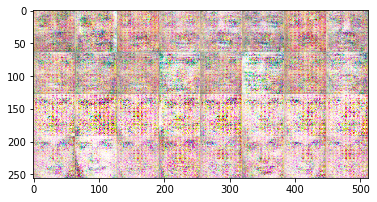

EPOCH 101 step 10350: D: loss = 0.4841758 G: loss=1.5752978 
EPOCH 101 step 10400: D: loss = 0.5031951 G: loss=1.5796225 
EPOCH 102 step 10450: D: loss = 0.4434279 G: loss=1.5487226 
EPOCH 102 step 10500: D: loss = 0.4460706 G: loss=1.4968176 
EPOCH 103 step 10550: D: loss = 0.4532682 G: loss=1.5570421 
EPOCH 103 step 10600: D: loss = 0.5881526 G: loss=1.6902537 
EPOCH 104 step 10650: D: loss = 0.4273006 G: loss=1.5858442 
EPOCH 104 step 10700: D: loss = 0.4628567 G: loss=1.5821329 
EPOCH 105 step 10750: D: loss = 0.4284003 G: loss=1.6188538 
EPOCH 105 step 10800: D: loss = 0.4371403 G: loss=1.6286364 
EPOCH 106 step 10850: D: loss = 0.4004080 G: loss=1.6720864 
EPOCH 106 step 10900: D: loss = 0.4997716 G: loss=1.7461367 
EPOCH 107 step 10950: D: loss = 0.4107373 G: loss=1.6225471 
EPOCH 107 step 11000: D: loss = 0.4212013 G: loss=1.6950302 
EPOCH 108 step 11050: D: loss = 0.4506464 G: loss=1.6978457 
EPOCH 108 step 11100: D: loss = 0.4070125 G: loss=1.5777771 
EPOCH 109 step 11150: D:

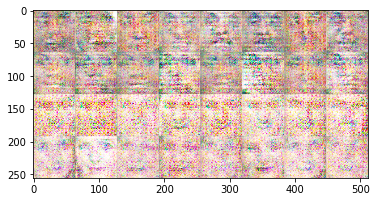

EPOCH 111 step 11350: D: loss = 0.3777806 G: loss=1.7460647 
EPOCH 111 step 11400: D: loss = 0.4402153 G: loss=1.6167358 
EPOCH 112 step 11450: D: loss = 0.4143931 G: loss=1.6503015 
EPOCH 112 step 11500: D: loss = 0.4698980 G: loss=1.5241050 
EPOCH 113 step 11550: D: loss = 0.3960246 G: loss=1.6565993 
EPOCH 113 step 11600: D: loss = 0.4338157 G: loss=1.6329522 
EPOCH 114 step 11650: D: loss = 0.3657845 G: loss=1.7194294 
EPOCH 114 step 11700: D: loss = 0.4137952 G: loss=1.6008482 
EPOCH 115 step 11750: D: loss = 0.4060383 G: loss=1.7754990 
EPOCH 115 step 11800: D: loss = 0.3872439 G: loss=1.7610925 
EPOCH 116 step 11850: D: loss = 0.3855625 G: loss=1.6634573 
EPOCH 116 step 11900: D: loss = 0.3905831 G: loss=1.7127244 
EPOCH 117 step 11950: D: loss = 0.3950056 G: loss=1.7772522 
EPOCH 117 step 12000: D: loss = 0.5225496 G: loss=1.9603028 
EPOCH 118 step 12050: D: loss = 0.3805756 G: loss=1.6940522 
EPOCH 118 step 12100: D: loss = 0.3951654 G: loss=1.7485344 
EPOCH 119 step 12150: D:

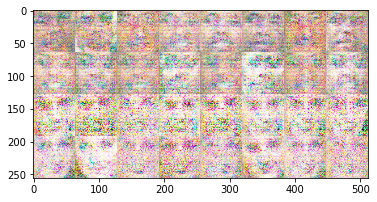

EPOCH 121 step 12350: D: loss = 0.3749576 G: loss=1.9510585 
EPOCH 121 step 12400: D: loss = 0.3691767 G: loss=1.9470950 
EPOCH 122 step 12450: D: loss = 0.3731120 G: loss=1.8075960 
EPOCH 122 step 12500: D: loss = 0.3917355 G: loss=1.7386407 
EPOCH 123 step 12550: D: loss = 0.4755273 G: loss=2.0215740 
EPOCH 123 step 12600: D: loss = 0.3791844 G: loss=1.9629687 
EPOCH 124 step 12650: D: loss = 0.3965575 G: loss=1.7482433 
EPOCH 124 step 12700: D: loss = 0.3439562 G: loss=1.7281568 
EPOCH 124 step 12750: D: loss = 0.3361222 G: loss=1.7116144 
EPOCH 125 step 12800: D: loss = 0.3318485 G: loss=1.9082775 
EPOCH 125 step 12850: D: loss = 0.3504509 G: loss=1.7944546 
EPOCH 126 step 12900: D: loss = 0.3419973 G: loss=1.9668593 
EPOCH 126 step 12950: D: loss = 0.3827322 G: loss=1.7387538 
EPOCH 127 step 13000: D: loss = 0.3573086 G: loss=1.9181123 
EPOCH 127 step 13050: D: loss = 0.8638731 G: loss=2.5338938 
EPOCH 128 step 13100: D: loss = 0.3140523 G: loss=1.9342642 
EPOCH 128 step 13150: D:

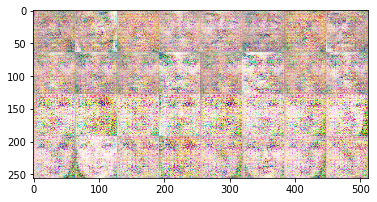

EPOCH 131 step 13400: D: loss = 0.3570355 G: loss=2.0965657 
EPOCH 131 step 13450: D: loss = 0.3226422 G: loss=1.9737914 
EPOCH 132 step 13500: D: loss = 0.3172269 G: loss=1.9368420 
EPOCH 132 step 13550: D: loss = 0.3836812 G: loss=2.0743103 
EPOCH 133 step 13600: D: loss = 0.3157636 G: loss=1.9753280 
EPOCH 133 step 13650: D: loss = 0.3165712 G: loss=2.0275586 
EPOCH 134 step 13700: D: loss = 0.3052020 G: loss=1.9831127 
EPOCH 134 step 13750: D: loss = 0.3630229 G: loss=1.9827204 
EPOCH 135 step 13800: D: loss = 0.3567646 G: loss=2.0391412 
EPOCH 135 step 13850: D: loss = 0.3197108 G: loss=2.0053909 
EPOCH 136 step 13900: D: loss = 0.3555366 G: loss=2.0639524 
EPOCH 136 step 13950: D: loss = 0.3651518 G: loss=1.9606229 
EPOCH 137 step 14000: D: loss = 0.4403183 G: loss=2.1763902 
EPOCH 137 step 14050: D: loss = 0.3638543 G: loss=1.9427416 
EPOCH 138 step 14100: D: loss = 0.3169819 G: loss=2.3002281 
EPOCH 138 step 14150: D: loss = 0.3837029 G: loss=2.3821900 
EPOCH 139 step 14200: D:

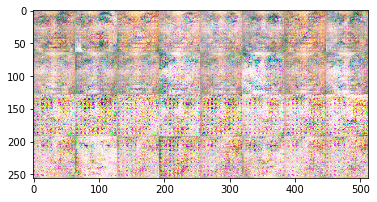

EPOCH 141 step 14400: D: loss = 0.2837027 G: loss=2.1855154 
EPOCH 141 step 14450: D: loss = 0.3159312 G: loss=2.2011566 
EPOCH 142 step 14500: D: loss = 0.2812604 G: loss=1.9792559 
EPOCH 142 step 14550: D: loss = 0.3107537 G: loss=2.2175791 
EPOCH 143 step 14600: D: loss = 0.2638092 G: loss=2.1922548 
EPOCH 143 step 14650: D: loss = 0.4508826 G: loss=2.4660897 
EPOCH 144 step 14700: D: loss = 0.3003402 G: loss=2.2077537 
EPOCH 144 step 14750: D: loss = 0.4721810 G: loss=2.1992755 
EPOCH 145 step 14800: D: loss = 0.2647385 G: loss=2.0440409 
EPOCH 145 step 14850: D: loss = 1.0374693 G: loss=2.6891260 
EPOCH 146 step 14900: D: loss = 0.2667653 G: loss=2.2236071 
EPOCH 146 step 14950: D: loss = 0.3008081 G: loss=2.3905139 
EPOCH 147 step 15000: D: loss = 0.3303376 G: loss=2.4679298 
EPOCH 147 step 15050: D: loss = 0.7314920 G: loss=3.6150236 
EPOCH 148 step 15100: D: loss = 0.2537447 G: loss=2.2271850 
EPOCH 148 step 15150: D: loss = 0.2573257 G: loss=2.3484313 
EPOCH 149 step 15200: D:

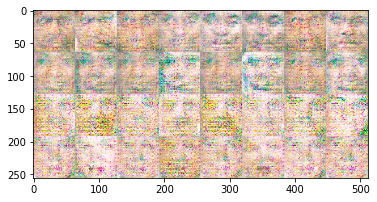

EPOCH 151 step 15450: D: loss = 0.2620434 G: loss=2.1990016 
EPOCH 151 step 15500: D: loss = 0.2893617 G: loss=2.3405352 
EPOCH 152 step 15550: D: loss = 0.2628819 G: loss=2.0814419 
EPOCH 152 step 15600: D: loss = 0.2728072 G: loss=2.2483354 
EPOCH 153 step 15650: D: loss = 0.2737390 G: loss=2.2216849 
EPOCH 153 step 15700: D: loss = 0.3172254 G: loss=2.5528977 
EPOCH 154 step 15750: D: loss = 0.2551880 G: loss=2.4259129 
EPOCH 154 step 15800: D: loss = 0.2424594 G: loss=2.5457718 
EPOCH 155 step 15850: D: loss = 0.2835589 G: loss=2.3106580 
EPOCH 155 step 15900: D: loss = 0.7080764 G: loss=2.8896723 
EPOCH 156 step 15950: D: loss = 0.3906403 G: loss=2.4866574 
EPOCH 156 step 16000: D: loss = 0.2965749 G: loss=2.5633845 
EPOCH 157 step 16050: D: loss = 0.2817568 G: loss=2.4971683 
EPOCH 157 step 16100: D: loss = 0.3447853 G: loss=2.5226696 
EPOCH 158 step 16150: D: loss = 0.2873097 G: loss=2.2500412 
EPOCH 158 step 16200: D: loss = 0.2488804 G: loss=2.3000963 
EPOCH 159 step 16250: D:

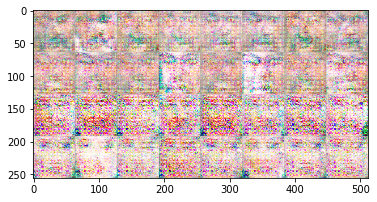

EPOCH 161 step 16450: D: loss = 0.2462510 G: loss=2.5952649 
EPOCH 161 step 16500: D: loss = 0.3582421 G: loss=2.4011288 
EPOCH 162 step 16550: D: loss = 0.2141640 G: loss=2.4167736 
EPOCH 162 step 16600: D: loss = 0.3238843 G: loss=2.4686282 
EPOCH 163 step 16650: D: loss = 0.2551795 G: loss=2.3847160 
EPOCH 163 step 16700: D: loss = 0.2350241 G: loss=2.5769508 
EPOCH 164 step 16750: D: loss = 0.2276997 G: loss=2.4330075 
EPOCH 164 step 16800: D: loss = 0.2343263 G: loss=2.4777186 
EPOCH 165 step 16850: D: loss = 0.3395872 G: loss=2.7625241 
EPOCH 165 step 16900: D: loss = 0.3224182 G: loss=2.8644543 
EPOCH 166 step 16950: D: loss = 0.3753377 G: loss=2.7104521 
EPOCH 166 step 17000: D: loss = 0.2344847 G: loss=2.6606514 
EPOCH 167 step 17050: D: loss = 0.3641835 G: loss=2.7792361 
EPOCH 167 step 17100: D: loss = 0.2379888 G: loss=2.5519094 
EPOCH 168 step 17150: D: loss = 0.2310858 G: loss=2.4171736 
EPOCH 168 step 17200: D: loss = 0.3224808 G: loss=2.9547782 
EPOCH 169 step 17250: D:

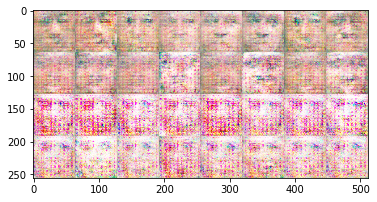

EPOCH 171 step 17450: D: loss = 0.2178685 G: loss=2.5447018 
EPOCH 171 step 17500: D: loss = 0.2500811 G: loss=2.7365160 
EPOCH 172 step 17550: D: loss = 0.2171090 G: loss=2.7190585 
EPOCH 172 step 17600: D: loss = 0.2747891 G: loss=2.5392509 
EPOCH 173 step 17650: D: loss = 0.3085321 G: loss=2.4434597 
EPOCH 173 step 17700: D: loss = 0.1966249 G: loss=2.5361934 
EPOCH 174 step 17750: D: loss = 0.3191298 G: loss=2.5040979 
EPOCH 174 step 17800: D: loss = 0.3233277 G: loss=2.6270030 
EPOCH 174 step 17850: D: loss = 0.1964794 G: loss=2.4144433 
EPOCH 175 step 17900: D: loss = 0.2237055 G: loss=2.3986642 
EPOCH 175 step 17950: D: loss = 0.2211061 G: loss=2.5961094 
EPOCH 176 step 18000: D: loss = 0.2467998 G: loss=2.6304584 
EPOCH 176 step 18050: D: loss = 0.2101621 G: loss=2.8386407 
EPOCH 177 step 18100: D: loss = 0.2399276 G: loss=2.6698439 
EPOCH 177 step 18150: D: loss = 0.2359045 G: loss=2.5692739 
EPOCH 178 step 18200: D: loss = 0.2424231 G: loss=2.4599059 
EPOCH 178 step 18250: D:

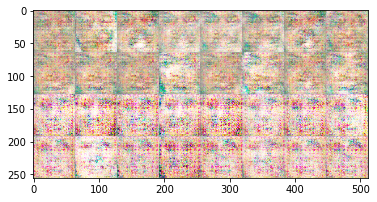

EPOCH 181 step 18500: D: loss = 0.1995816 G: loss=2.6136985 
EPOCH 181 step 18550: D: loss = 0.2295555 G: loss=2.7660058 
EPOCH 182 step 18600: D: loss = 0.3234502 G: loss=2.7466855 
EPOCH 182 step 18650: D: loss = 0.1849061 G: loss=2.7136588 
EPOCH 183 step 18700: D: loss = 0.1944073 G: loss=2.6437716 
EPOCH 183 step 18750: D: loss = 0.2617817 G: loss=2.7158022 
EPOCH 184 step 18800: D: loss = 0.3323444 G: loss=2.7596464 
EPOCH 184 step 18850: D: loss = 0.1807039 G: loss=2.6778383 
EPOCH 185 step 18900: D: loss = 0.2310944 G: loss=2.4539633 
EPOCH 185 step 18950: D: loss = 0.2685878 G: loss=2.7074041 
EPOCH 186 step 19000: D: loss = 0.2450711 G: loss=2.5986619 
EPOCH 186 step 19050: D: loss = 0.2178429 G: loss=2.4428477 
EPOCH 187 step 19100: D: loss = 0.2132689 G: loss=2.5473068 
EPOCH 187 step 19150: D: loss = 0.4853638 G: loss=3.9218509 
EPOCH 188 step 19200: D: loss = 0.2437355 G: loss=2.7256410 
EPOCH 188 step 19250: D: loss = 0.1871403 G: loss=2.6430109 
EPOCH 189 step 19300: D:

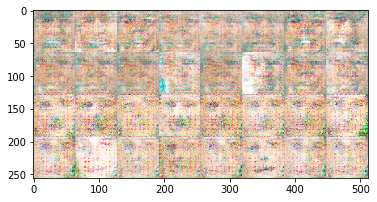

EPOCH 191 step 19500: D: loss = 0.2094884 G: loss=2.3998783 
EPOCH 191 step 19550: D: loss = 0.2176340 G: loss=2.3638835 
EPOCH 192 step 19600: D: loss = 0.2074408 G: loss=2.6648400 
EPOCH 192 step 19650: D: loss = 0.2078255 G: loss=2.8584371 
EPOCH 193 step 19700: D: loss = 0.7715698 G: loss=4.8050961 
EPOCH 193 step 19750: D: loss = 0.1217547 G: loss=3.2477040 
EPOCH 194 step 19800: D: loss = 0.1773335 G: loss=2.9628508 
EPOCH 194 step 19850: D: loss = 0.1426039 G: loss=2.8413227 
EPOCH 195 step 19900: D: loss = 0.2017390 G: loss=2.7111619 
EPOCH 195 step 19950: D: loss = 0.1594041 G: loss=2.9772303 
EPOCH 196 step 20000: D: loss = 0.2286380 G: loss=2.7111259 
EPOCH 196 step 20050: D: loss = 0.1698832 G: loss=2.7742906 
EPOCH 197 step 20100: D: loss = 0.2107214 G: loss=2.6752157 
EPOCH 197 step 20150: D: loss = 0.1781917 G: loss=2.6816425 
EPOCH 198 step 20200: D: loss = 0.1954343 G: loss=2.8362751 
EPOCH 198 step 20250: D: loss = 0.1885804 G: loss=2.5902276 
EPOCH 199 step 20300: D:

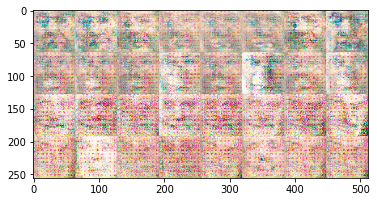

EPOCH 201 step 20550: D: loss = 0.2038832 G: loss=2.8421662 
EPOCH 201 step 20600: D: loss = 0.2917367 G: loss=2.9790170 
EPOCH 202 step 20650: D: loss = 0.2988974 G: loss=2.8882091 
EPOCH 202 step 20700: D: loss = 0.1752346 G: loss=2.5534813 
EPOCH 203 step 20750: D: loss = 0.2788414 G: loss=2.5853271 
EPOCH 203 step 20800: D: loss = 0.2702387 G: loss=2.7108240 
EPOCH 204 step 20850: D: loss = 0.2234830 G: loss=2.6321864 
EPOCH 204 step 20900: D: loss = 0.1593894 G: loss=2.9775522 
EPOCH 205 step 20950: D: loss = 0.2050305 G: loss=2.6441414 
EPOCH 205 step 21000: D: loss = 0.2855434 G: loss=3.2354641 
EPOCH 206 step 21050: D: loss = 0.1806743 G: loss=3.1626692 
EPOCH 206 step 21100: D: loss = 0.2218496 G: loss=2.8325791 
EPOCH 207 step 21150: D: loss = 0.2077360 G: loss=2.7019010 
EPOCH 207 step 21200: D: loss = 0.2692282 G: loss=3.2891283 
EPOCH 208 step 21250: D: loss = 0.2576544 G: loss=2.6989377 
EPOCH 208 step 21300: D: loss = 0.2513851 G: loss=2.6408064 
EPOCH 209 step 21350: D:

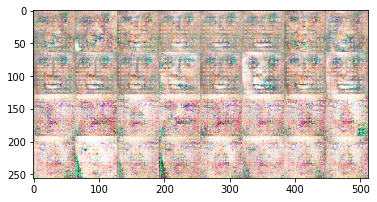

EPOCH 211 step 21550: D: loss = 0.3284822 G: loss=3.2280903 
EPOCH 211 step 21600: D: loss = 0.2710588 G: loss=2.8283734 
EPOCH 212 step 21650: D: loss = 0.2174969 G: loss=3.0962834 
EPOCH 212 step 21700: D: loss = 0.2116522 G: loss=2.4157026 
EPOCH 213 step 21750: D: loss = 0.2946737 G: loss=2.7026420 
EPOCH 213 step 21800: D: loss = 0.1876349 G: loss=2.6954279 
EPOCH 214 step 21850: D: loss = 0.1838672 G: loss=2.8557563 
EPOCH 214 step 21900: D: loss = 0.2590115 G: loss=3.0185664 
EPOCH 215 step 21950: D: loss = 0.1856114 G: loss=2.9517026 
EPOCH 215 step 22000: D: loss = 0.2003397 G: loss=2.8939619 
EPOCH 216 step 22050: D: loss = 0.2889546 G: loss=2.5130193 
EPOCH 216 step 22100: D: loss = 0.2053127 G: loss=3.7222152 
EPOCH 217 step 22150: D: loss = 0.1793406 G: loss=3.3342533 
EPOCH 217 step 22200: D: loss = 0.1654141 G: loss=3.4357886 
EPOCH 218 step 22250: D: loss = 0.1523505 G: loss=3.0459738 
EPOCH 218 step 22300: D: loss = 0.1889532 G: loss=3.0074787 
EPOCH 219 step 22350: D:

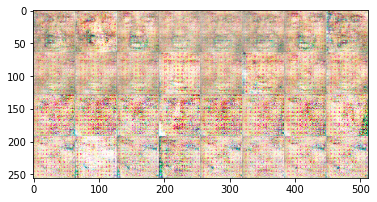

EPOCH 221 step 22550: D: loss = 0.1773080 G: loss=2.8475115 
EPOCH 221 step 22600: D: loss = 0.1864045 G: loss=2.8625569 
EPOCH 222 step 22650: D: loss = 0.1757837 G: loss=3.0382221 
EPOCH 222 step 22700: D: loss = 0.4962818 G: loss=4.7693858 
EPOCH 223 step 22750: D: loss = 0.1490283 G: loss=4.0184278 
EPOCH 223 step 22800: D: loss = 0.1115868 G: loss=3.2236607 
EPOCH 224 step 22850: D: loss = 0.1502283 G: loss=3.0868185 
EPOCH 224 step 22900: D: loss = 0.2398512 G: loss=3.0677550 
EPOCH 224 step 22950: D: loss = 0.1897030 G: loss=2.7448919 
EPOCH 225 step 23000: D: loss = 0.1955378 G: loss=2.6417489 
EPOCH 225 step 23050: D: loss = 0.3339504 G: loss=3.0888705 
EPOCH 226 step 23100: D: loss = 0.1663379 G: loss=2.9160032 
EPOCH 226 step 23150: D: loss = 0.1929864 G: loss=2.9381397 
EPOCH 227 step 23200: D: loss = 0.1487959 G: loss=2.9216347 
EPOCH 227 step 23250: D: loss = 0.2148333 G: loss=3.0558221 
EPOCH 228 step 23300: D: loss = 0.3174774 G: loss=3.4391568 
EPOCH 228 step 23350: D:

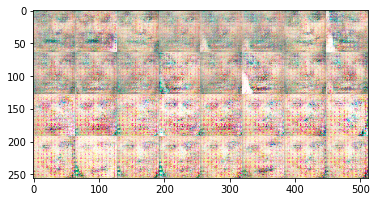

EPOCH 231 step 23600: D: loss = 0.1445915 G: loss=3.0065279 
EPOCH 231 step 23650: D: loss = 0.1829494 G: loss=2.7725956 
EPOCH 232 step 23700: D: loss = 0.2177698 G: loss=2.8507943 
EPOCH 232 step 23750: D: loss = 0.1412263 G: loss=2.9982913 
EPOCH 233 step 23800: D: loss = 0.3256487 G: loss=2.8719108 
EPOCH 233 step 23850: D: loss = 0.1924736 G: loss=2.7708273 
EPOCH 234 step 23900: D: loss = 0.4032381 G: loss=3.2215271 
EPOCH 234 step 23950: D: loss = 0.1851610 G: loss=3.0160010 
EPOCH 235 step 24000: D: loss = 0.1690253 G: loss=2.8740911 
EPOCH 235 step 24050: D: loss = 0.1506011 G: loss=3.1057010 
EPOCH 236 step 24100: D: loss = 0.2003175 G: loss=2.8747277 
EPOCH 236 step 24150: D: loss = 0.1917029 G: loss=2.7593021 
EPOCH 237 step 24200: D: loss = 0.1795483 G: loss=2.8668196 
EPOCH 237 step 24250: D: loss = 0.1981617 G: loss=3.0158365 
EPOCH 238 step 24300: D: loss = 0.2036035 G: loss=2.8853660 
EPOCH 238 step 24350: D: loss = 0.2255347 G: loss=3.0022311 
EPOCH 239 step 24400: D:

EPOCH 241 step 24600: D: loss = 0.2004507 G: loss=2.8496628 
EPOCH 241 step 24650: D: loss = 0.2082291 G: loss=2.7629042 
EPOCH 242 step 24700: D: loss = 0.1864903 G: loss=3.0326164 
EPOCH 242 step 24750: D: loss = 0.1263090 G: loss=3.4085524 
EPOCH 243 step 24800: D: loss = 0.1574063 G: loss=3.0096610 
EPOCH 243 step 24850: D: loss = 0.1779130 G: loss=3.1259623 
EPOCH 244 step 24900: D: loss = 0.1800881 G: loss=2.9626050 
EPOCH 244 step 24950: D: loss = 0.2608759 G: loss=3.7947109 
EPOCH 245 step 25000: D: loss = 0.1786806 G: loss=2.8845189 
EPOCH 245 step 25050: D: loss = 0.5794592 G: loss=3.6557777 
EPOCH 246 step 25100: D: loss = 0.1661140 G: loss=2.7900925 
EPOCH 246 step 25150: D: loss = 0.1700687 G: loss=2.9689112 
EPOCH 247 step 25200: D: loss = 0.1835905 G: loss=3.1883078 
EPOCH 247 step 25250: D: loss = 0.1978465 G: loss=3.0394828 
EPOCH 248 step 25300: D: loss = 0.2684486 G: loss=3.0453570 
EPOCH 248 step 25350: D: loss = 0.1357343 G: loss=3.0522451 
EPOCH 249 step 25400: D:

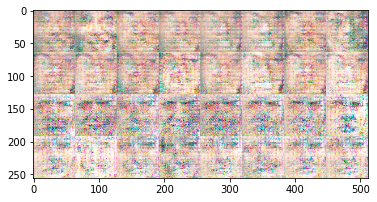

EPOCH 251 step 25650: D: loss = 0.1512200 G: loss=3.6725161 
EPOCH 251 step 25700: D: loss = 0.1469745 G: loss=3.2504368 
EPOCH 252 step 25750: D: loss = 0.1612953 G: loss=2.7374728 
EPOCH 252 step 25800: D: loss = 0.1657155 G: loss=3.0050044 
EPOCH 253 step 25850: D: loss = 0.3147975 G: loss=2.8005147 
EPOCH 253 step 25900: D: loss = 0.3282983 G: loss=3.3953018 
EPOCH 254 step 25950: D: loss = 0.1927812 G: loss=2.8242362 
EPOCH 254 step 26000: D: loss = 0.1968439 G: loss=3.0184197 
EPOCH 255 step 26050: D: loss = 0.1630826 G: loss=2.8470314 
EPOCH 255 step 26100: D: loss = 0.4594260 G: loss=4.1369238 
EPOCH 256 step 26150: D: loss = 0.1195829 G: loss=3.3791709 
EPOCH 256 step 26200: D: loss = 0.4985274 G: loss=3.6031587 
EPOCH 257 step 26250: D: loss = 0.1958167 G: loss=2.9195518 
EPOCH 257 step 26300: D: loss = 0.3093160 G: loss=3.1362410 
EPOCH 258 step 26350: D: loss = 0.1568376 G: loss=3.0236926 
EPOCH 258 step 26400: D: loss = 0.1635394 G: loss=2.8899848 
EPOCH 259 step 26450: D:

EPOCH 261 step 26650: D: loss = 0.1897553 G: loss=2.8609786 
EPOCH 261 step 26700: D: loss = 0.1549356 G: loss=2.8008206 
EPOCH 262 step 26750: D: loss = 0.1329404 G: loss=3.1527295 
EPOCH 262 step 26800: D: loss = 0.1530252 G: loss=2.8930557 
EPOCH 263 step 26850: D: loss = 0.1772720 G: loss=2.8915987 
EPOCH 263 step 26900: D: loss = 0.1557780 G: loss=2.8749213 
EPOCH 264 step 26950: D: loss = 0.2384048 G: loss=2.9708676 
EPOCH 264 step 27000: D: loss = 0.2977629 G: loss=3.5107105 
EPOCH 265 step 27050: D: loss = 0.1602153 G: loss=3.2494109 
EPOCH 265 step 27100: D: loss = 0.2092659 G: loss=3.0572715 
EPOCH 266 step 27150: D: loss = 0.3893162 G: loss=3.5676737 
EPOCH 266 step 27200: D: loss = 0.2292258 G: loss=2.8659825 
EPOCH 267 step 27250: D: loss = 0.1937541 G: loss=3.3134468 
EPOCH 267 step 27300: D: loss = 0.1837083 G: loss=3.6831255 
EPOCH 268 step 27350: D: loss = 0.1823223 G: loss=2.8138981 
EPOCH 268 step 27400: D: loss = 0.1917978 G: loss=3.5459747 
EPOCH 269 step 27450: D:

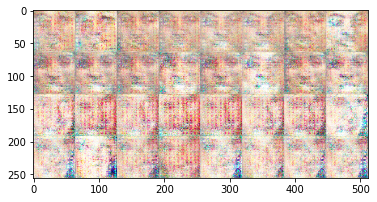

EPOCH 271 step 27650: D: loss = 0.1643616 G: loss=3.3401380 
EPOCH 271 step 27700: D: loss = 0.2351902 G: loss=3.6181912 
EPOCH 272 step 27750: D: loss = 0.1765785 G: loss=2.9813232 
EPOCH 272 step 27800: D: loss = 0.1381082 G: loss=3.2541976 
EPOCH 273 step 27850: D: loss = 0.1884752 G: loss=3.0651860 
EPOCH 273 step 27900: D: loss = 0.1530027 G: loss=3.3526335 
EPOCH 274 step 27950: D: loss = 0.2991810 G: loss=3.3709872 
EPOCH 274 step 28000: D: loss = 0.1813038 G: loss=2.6983280 
EPOCH 274 step 28050: D: loss = 0.1562303 G: loss=2.8635764 
EPOCH 275 step 28100: D: loss = 0.1967239 G: loss=3.1626277 
EPOCH 275 step 28150: D: loss = 0.2520715 G: loss=3.5066941 
EPOCH 276 step 28200: D: loss = 0.1395272 G: loss=3.3624606 
EPOCH 276 step 28250: D: loss = 0.1714937 G: loss=3.2682850 
EPOCH 277 step 28300: D: loss = 0.5338464 G: loss=3.7896323 
EPOCH 277 step 28350: D: loss = 0.2044206 G: loss=3.9834883 
EPOCH 278 step 28400: D: loss = 0.1603788 G: loss=2.9789119 
EPOCH 278 step 28450: D:

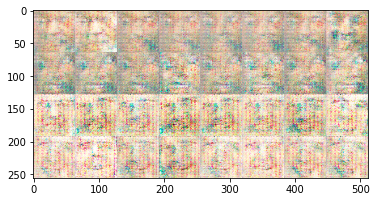

EPOCH 281 step 28700: D: loss = 0.1566353 G: loss=4.4965391 
EPOCH 281 step 28750: D: loss = 0.2114393 G: loss=3.8566642 
EPOCH 282 step 28800: D: loss = 0.1731211 G: loss=3.2772796 
EPOCH 282 step 28850: D: loss = 0.2527529 G: loss=3.7844062 
EPOCH 283 step 28900: D: loss = 0.1465675 G: loss=2.9438591 
EPOCH 283 step 28950: D: loss = 0.4443732 G: loss=3.4246089 
EPOCH 284 step 29000: D: loss = 0.3208366 G: loss=3.2306092 
EPOCH 284 step 29050: D: loss = 0.1505960 G: loss=2.9629364 
EPOCH 285 step 29100: D: loss = 0.1504314 G: loss=3.1764402 
EPOCH 285 step 29150: D: loss = 0.1791308 G: loss=3.1208353 
EPOCH 286 step 29200: D: loss = 0.1867458 G: loss=3.0107193 
EPOCH 286 step 29250: D: loss = 0.1691613 G: loss=2.8575630 
EPOCH 287 step 29300: D: loss = 0.1337180 G: loss=3.1385922 
EPOCH 287 step 29350: D: loss = 0.1903560 G: loss=3.2285912 
EPOCH 288 step 29400: D: loss = 0.1747527 G: loss=2.8732362 
EPOCH 288 step 29450: D: loss = 0.1533968 G: loss=2.9659815 
EPOCH 289 step 29500: D:

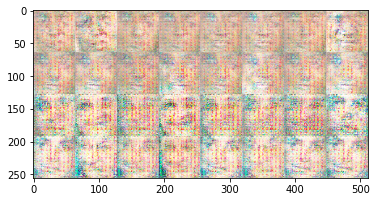

EPOCH 291 step 29700: D: loss = 0.2665213 G: loss=3.2642083 
EPOCH 291 step 29750: D: loss = 0.1575146 G: loss=3.0942230 
EPOCH 292 step 29800: D: loss = 0.2021119 G: loss=3.1721869 
EPOCH 292 step 29850: D: loss = 0.1852225 G: loss=3.6373558 
EPOCH 293 step 29900: D: loss = 0.1560836 G: loss=2.9059930 
EPOCH 293 step 29950: D: loss = 0.2299178 G: loss=3.5318768 
EPOCH 294 step 30000: D: loss = 0.1572704 G: loss=3.1744719 
EPOCH 294 step 30050: D: loss = 0.3605716 G: loss=4.2766223 
EPOCH 295 step 30100: D: loss = 0.1677785 G: loss=3.0426636 
EPOCH 295 step 30150: D: loss = 1.0183786 G: loss=5.1709161 
EPOCH 296 step 30200: D: loss = 0.1590355 G: loss=2.9283266 
EPOCH 296 step 30250: D: loss = 0.1829585 G: loss=3.5648220 
EPOCH 297 step 30300: D: loss = 0.1378962 G: loss=3.6827924 
EPOCH 297 step 30350: D: loss = 0.1799658 G: loss=3.7135062 
EPOCH 298 step 30400: D: loss = 0.2425842 G: loss=3.9153643 
EPOCH 298 step 30450: D: loss = 0.1697031 G: loss=3.5676448 
EPOCH 299 step 30500: D:

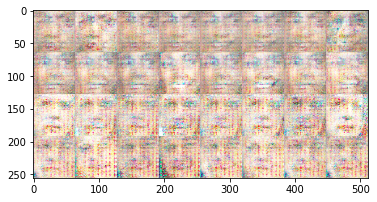

In [12]:
#### TODO ####
def new_sample_label_face(num):
    label_vector = np.zeros((num,3))
    for i in range(32):
        # row 1
        if i % 4 == 0:
            label_vector[i,0]= 2  # male
            label_vector[i,1]=-2  # not white
            label_vector[i,2]= 2  # black
        # row 2
        elif i % 4 == 1:
            label_vector[i,0]=-2  # female
            label_vector[i,1]=-2  # not white
            label_vector[i,2]= 2  # black
        # row 3
        elif i % 4 == 2:
            label_vector[i,0]= 2  # male
            label_vector[i,1]= 2  # white
            label_vector[i,2]=-2  # not black
        # row 4
        else:
            label_vector[i,0]=-2  # female
            label_vector[i,1]= 2  # white
            label_vector[i,2]=-2  # not black
    return label_vector

tf.reset_default_graph()

sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y , batch_size, y_dim,  False)

G_pro, G_logits = dis_net(fake_images , y , batch_size, y_dim, True)

# DEFINE LOSS FUNCTION #

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones_like(D_logits)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros_like(G_logits)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones_like(G_logits)))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im , label , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

        if np.mod(e , 10) == 0:

            sample_images = sess.run(fake_images ,
                                               feed_dict={z:sample_z , y:new_sample_label_face(batch_size)})
            sample_images = sample_images[:32,:,:,:]
            image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
            save_images(sample_images , [4,8] , image_name)
        
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()

        e = e + 1
        batch_num = 0